# Proyecto 1 - Business Intelligence



In [ ]:

# Librería para manejar las contracciones que se presentan en el inglés.
!pip install contractions
!pip install tokenizers


In [ ]:

# librería para manejar las flexiones gramaticales en el idioma inglés.
!pip install inflect
!pip install pandas-profiling==2.7.1


In [ ]:
# Importa la libreria 
import nltk
# Descarga paquetes adicionales
# Punkt permite separar un texto en frases.
nltk.download('punkt')
# Descarga todas las palabras vacias, es decir, aquellas que no aportan nada al significado del texto
nltk.download('stopwords')
# Descarga de paquete WordNetLemmatizer, este es usado para encontrar el lema de cada palabra
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Importación de librerias
seed = 161
import pandas as pd
import numpy as np
import sys
from pandas_profiling import ProfileReport
import contractions

import re, string, unicodedata
##import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, plot_precision_recall_curve
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt# Para evaluar el modelo
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import plot_confusion_matrix

# Seaborn
import seaborn as sns 
from sklearn import tree

# Para búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV
# Para la validación cruzada
from sklearn.model_selection import KFold 

# Para crear el arbol de decisión 
from sklearn.tree import DecisionTreeClassifier 

## Perfilamiento y entendimiento de los datos
lecutra de los datos.


In [ ]:
# Uso de la libreria pandas para la lectura de archivos
data=pd.read_csv('kindle_reviews.csv', sep=',', encoding = 'utf-8', index_col=0, nrows=15000)
data=data.drop(columns=['overall', 'asin', 'reviewTime', 'reviewerID', 'reviewerName', 'unixReviewTime'], axis=1);
# Asignación a una nueva variable de los datos leidos
data_t=data.copy()
data_t.sample(10)

,helpful,reviewText,summary
7066,"[1, 2]",Aggie proves once again that an observant eye ...,Lighthearted Reading For The Senior Set
3456,"[0, 0]",This is one of those rare books that draws you...,"Lovely, lovely book"
11937,"[0, 0]",I ordered this book form my wireless kindle th...,another stupid review
7372,"[0, 0]",Wasn't sure what I was getting into here but i...,Fun read
9526,"[0, 0]",I've read two books recently with a blind hero...,First-rate story with a Pinterist board to ill...
9169,"[1, 1]",Life is cheap in the far-future world of Rogue...,"Short, action-packed, comic-book sci-fi fiction"
405,"[0, 0]",A BIT DIFFERENT FROM WHAT I EXPECTED. IT WAS ...,INTERESTING
4534,"[0, 0]",Col Autry and his fellow soldiers of X Bat lig...,Sky Hunters: Operation Southern Cross
10696,"[1, 1]","I don't normally read historicals, or alternat...",Confusing
10113,"[3, 4]",At first this book was OK. The author was a li...,Awful


In [ ]:
data_t.shape

(15000, 3)

In [ ]:
data_t["reviewText"]=data_t["reviewText"].astype(str)

In [ ]:
data_t.dtypes

helpful       object
reviewText    object
summary       object
dtype: object

In [ ]:
textos = data_t.copy()
textos['Conteo'] = [len(x) for x in textos['reviewText']]
textos['Moda'] = [max(set(x.split(' ')), key = x.split(' ').count) for x in textos['reviewText']]
textos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['reviewText']]
textos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['reviewText']]
textos.sample(10)

,helpful,reviewText,summary,Conteo,Moda,Max,Min
9903,"[3, 3]",This is a short and touching story about a est...,Cruising at the wedding?,362,the,10,1
2595,"[1, 2]",The story wasn't too bad - what little there w...,"Very, very short",138,was,10,1
9051,"[1, 1]",Good space opera with a sense of humor that do...,Prime Obsession,231,the,12,0
4815,"[0, 0]","The humor was not as funny as he other books, ...",Not as good as the others,139,was,8,1
1542,"[0, 0]",Love shifter stories and i really liked this o...,Too Short,225,the,7,0
11283,"[0, 0]",The story backdrop is a small town rural mount...,Engaging Dual View Point Thriller *****,984,a,13,0
12388,"[0, 0]",This was a very well written story i enjoyed r...,loved it,122,i,7,1
2199,"[3, 4]",This is one of my favorite Harlequins. I've r...,One of my favorite Harlequins,331,,12,0
14449,"[4, 6]","I did not enjoy this book at all. Trey, the l...",Don't bother,440,,11,0
10991,"[0, 0]",I love this book and can not wait to start rea...,Another great Lora Leigh book,245,the,11,0



##3. Preparación de datos
###3.1 Limpieza de los datos

In [ ]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words
    

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words


def preprocessing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

###3.2 Tokenización

In [ ]:
data_t['reviewText'] = data_t['reviewText'].apply(contractions.fix) #Aplica la corrección de las contracciones

In [ ]:
data_t['words'] = data_t['reviewText'].apply(word_tokenize).apply(preprocessing) #Aplica la eliminación del ruido
data_t.head()

,helpful,reviewText,summary,words
0,"[0, 0]",I enjoy vintage books and movies so I enjoyed ...,Nice vintage story,"[enjoy, vintage, books, movies, enjoyed, readi..."
1,"[2, 2]",This book is a reissue of an old one; the auth...,Different...,"[book, reissue, old, one, author, born, 1910, ..."
2,"[2, 2]",This was a fairly interesting read. It had ol...,Oldie,"[fairly, interesting, read, old, style, termin..."
3,"[1, 1]",I would never read any of the Amy Brewster mys...,I really liked it.,"[would, never, read, amy, brewster, mysteries,..."
4,"[0, 1]","If you like period pieces - clothing, lingo, y...",Period Mystery,"[like, period, pieces, clothing, lingo, enjoy,..."


### 3.3 Normalizacion

In [ ]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

data_t['words'] = data_t['words'].apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
data_t.head()

,helpful,reviewText,summary,words
0,"[0, 0]",I enjoy vintage books and movies so I enjoyed ...,Nice vintage story,"[enjoy, vint, book, movy, enjoy, read, book, p..."
1,"[2, 2]",This book is a reissue of an old one; the auth...,Different...,"[book, reissu, old, on, auth, born, 1910, er, ..."
2,"[2, 2]",This was a fairly interesting read. It had ol...,Oldie,"[fair, interest, read, old, styl, terminology,..."
3,"[1, 1]",I would never read any of the Amy Brewster mys...,I really liked it.,"[would, nev, read, amy, brewst, mystery, on, r..."
4,"[0, 1]","If you like period pieces - clothing, lingo, y...",Period Mystery,"[lik, period, piec, cloth, lingo, enjoy, myste..."


In [ ]:
# saving as a CSV file
data_t.to_csv('Datos.csv', sep ='\t')

### 3.4 Selección de campos

In [ ]:

data_t['message_processed'] = data_t['words'].apply(lambda x: ' '.join(map(str, x)))
data_t

,helpful,reviewText,summary,words,message_processed
0,"[0, 0]",I enjoy vintage books and movies so I enjoyed ...,Nice vintage story,"[enjoy, vint, book, movy, enjoy, read, book, p...",enjoy vint book movy enjoy read book plot unus...
1,"[2, 2]",This book is a reissue of an old one; the auth...,Different...,"[book, reissu, old, on, auth, born, 1910, er, ...",book reissu old on auth born 1910 er say nero ...
2,"[2, 2]",This was a fairly interesting read. It had ol...,Oldie,"[fair, interest, read, old, styl, terminology,...",fair interest read old styl terminology glad g...
3,"[1, 1]",I would never read any of the Amy Brewster mys...,I really liked it.,"[would, nev, read, amy, brewst, mystery, on, r...",would nev read amy brewst mystery on real hook...
4,"[0, 1]","If you like period pieces - clothing, lingo, y...",Period Mystery,"[lik, period, piec, cloth, lingo, enjoy, myste...",lik period piec cloth lingo enjoy mystery auth...
...,...,...,...,...,...
14995,"[0, 0]",This story is an amazing journey into the live...,spectacular story,"[story, amaz, journey, liv, peopl, realm, drag...",story amaz journey liv peopl realm dragon drak...
14996,"[0, 0]",ok i am not a person who talks alot so i will ...,ok,"[ok, person, talk, alot, short, point, lov, ok...",ok person talk alot short point lov ok person ...
14997,"[20, 21]",This is a classic fantasy story of Good vs. Ev...,"Good read, but didn't quite hit the mark","[class, fantasy, story, good, vs, evilit, com,...",class fantasy story good vs evilit com 6716 lo...
14998,"[2, 2]","With a large cast of characters, this story dr...",LEGENDS--First Book of LEGEND OF THE WHITE DRAGON,"[larg, cast, charact, story, draw, interest, i...",larg cast charact story draw interest immedy t...


In [ ]:
#Nuestra variable objetivo será helpful la cual nos permite analizar que tan buena es una review.
#Teniendo en cuenta que es un valor entre corchetes toca modificarlo [2,3] establecemos una funcion.

def Establecer(array) :
    numerador = int (array[0])
    denominador = int (array[1])
    if (numerador == 0 & denominador== 0):
      return 0
    else:
      return float(numerador/denominador)




In [ ]:
data_test = data_t.copy()

In [ ]:
data_test['helpfulCorregido'] = data_test.helpful.apply(lambda x: x.replace (' ',''))
data_test['helpfulCorregido'] = data_test.helpful.apply(lambda x: x[1:-1].split(','))

In [ ]:
data_test['helpful_Corregido'] = data_test.helpfulCorregido.apply(lambda s: Establecer(s))
data_test

,helpful,reviewText,summary,words,message_processed,helpfulCorregido,helpful_Corregido
0,"[0, 0]",I enjoy vintage books and movies so I enjoyed ...,Nice vintage story,"[enjoy, vint, book, movy, enjoy, read, book, p...",enjoy vint book movy enjoy read book plot unus...,"[0, 0]",0.000000
1,"[2, 2]",This book is a reissue of an old one; the auth...,Different...,"[book, reissu, old, on, auth, born, 1910, er, ...",book reissu old on auth born 1910 er say nero ...,"[2, 2]",1.000000
2,"[2, 2]",This was a fairly interesting read. It had ol...,Oldie,"[fair, interest, read, old, styl, terminology,...",fair interest read old styl terminology glad g...,"[2, 2]",1.000000
3,"[1, 1]",I would never read any of the Amy Brewster mys...,I really liked it.,"[would, nev, read, amy, brewst, mystery, on, r...",would nev read amy brewst mystery on real hook...,"[1, 1]",1.000000
4,"[0, 1]","If you like period pieces - clothing, lingo, y...",Period Mystery,"[lik, period, piec, cloth, lingo, enjoy, myste...",lik period piec cloth lingo enjoy mystery auth...,"[0, 1]",0.000000
...,...,...,...,...,...,...,...
14995,"[0, 0]",This story is an amazing journey into the live...,spectacular story,"[story, amaz, journey, liv, peopl, realm, drag...",story amaz journey liv peopl realm dragon drak...,"[0, 0]",0.000000
14996,"[0, 0]",ok i am not a person who talks alot so i will ...,ok,"[ok, person, talk, alot, short, point, lov, ok...",ok person talk alot short point lov ok person ...,"[0, 0]",0.000000
14997,"[20, 21]",This is a classic fantasy story of Good vs. Ev...,"Good read, but didn't quite hit the mark","[class, fantasy, story, good, vs, evilit, com,...",class fantasy story good vs evilit com 6716 lo...,"[20, 21]",0.952381
14998,"[2, 2]","With a large cast of characters, this story dr...",LEGENDS--First Book of LEGEND OF THE WHITE DRAGON,"[larg, cast, charact, story, draw, interest, i...",larg cast charact story draw interest immedy t...,"[2, 2]",1.000000


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


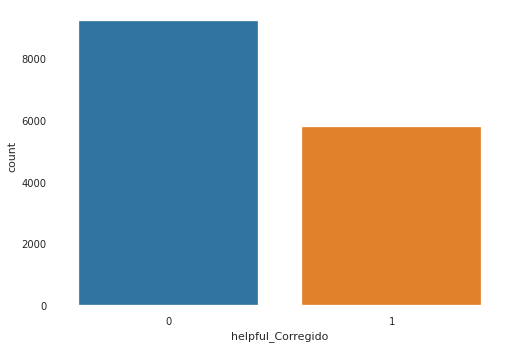

In [ ]:
X_data, y_data = data_test['message_processed'], data_test['helpful_Corregido']
y_data = (y_data >= 0.5).astype(int)  
y_data
ax = sns.countplot(y_data)

##Representacion de Final
###Para la representación final usaremos la Matriz Conteo: Matriz donde cada columna representa una palabra del diccionario final y cada fila un documento. Cada celda tiene el numero de veces que aparece la palabra correspondiente en el documento.

In [ ]:
#Matriz conteo
count = CountVectorizer()
X_count = count.fit_transform(X_data)
print(X_count.shape)
X_count.toarray()[0]

(15000, 55957)


array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
print(X_count)

  (0, 15383)	4
  (0, 53010)	1
  (0, 5864)	4
  (0, 32117)	1
  (0, 39511)	4
  (0, 37236)	2
  (0, 52195)	1
  (0, 49254)	2
  (0, 26865)	1
  (0, 45275)	2
  (0, 43056)	1
  (0, 27776)	1
  (0, 42506)	1
  (0, 5768)	2
  (0, 54728)	2
  (0, 33640)	1
  (0, 37459)	1
  (0, 22705)	2
  (0, 26043)	2
  (0, 27142)	2
  (0, 55214)	2
  (0, 53512)	2
  (0, 49950)	1
  (0, 20154)	2
  (0, 53011)	1
  :	:
  (14998, 15690)	1
  (14998, 3946)	1
  (14998, 3948)	1
  (14999, 5864)	2
  (14999, 39511)	2
  (14999, 55214)	2
  (14999, 54947)	1
  (14999, 29594)	1
  (14999, 55188)	1
  (14999, 46684)	4
  (14999, 29593)	1
  (14999, 928)	1
  (14999, 1010)	1
  (14999, 43554)	1
  (14999, 54327)	1
  (14999, 43377)	1
  (14999, 54328)	1
  (14999, 48478)	1
  (14999, 48509)	1
  (14999, 17837)	2
  (14999, 40765)	1
  (14999, 40766)	1
  (14999, 38078)	2
  (14999, 33997)	1
  (14999, 33998)	1


## 4. Creación y Aplicación del modelo
Una vez se tiene la representación vectorial de cada uno de los textos se debe crear un modelo que permita clasificarlos en las categorias correspondientes.


### Primer algoritmo - Arboles de Desición 

In [ ]:
X = X_count
Y = y_data
# Dividir los datos en entrenamiento y test
# Con este bloque tenemos la división de los datos de prueba y los de entrenamiento
# Tomaremos el 20% de los datos para hacer las pruebas.
size = 0.2

# input_df_test - Son los datos con los que probaremos el modelo
# objective_variable_test es la salida de la variable objetivo de los datos con los que probaremos el modelo
# input_df_train - Son los datos con los que entrenaremos el modelo
# objective_variable_train es la salida de los datos con la que probaremos el modelo

# objective_variable_test es la salida de la variable objetivo de los datos con los que probaremos el modelo
input_df_train, input_df_test, objective_variable_train, objective_variable_test =train_test_split(X, Y, test_size=size, random_state=0)


In [ ]:
# Crear el objeto de arbol de decisión. Optimizaremos los hiperparametros de una vez
# El random state lo dejamos en 0 para mantener el orden del randomization

# Fijemos el número de particiones. Utilizaremos K = 10.
particiones = KFold(n_splits=10, shuffle=True, random_state = 0)
# Establecemos el espacio de búsqueda para los hiperparámetros que deseamos ajustar. 
param_grid = {'criterion':['gini', 'entropy'],'max_depth':[3,5,7,9]}
# Definimos el modelo sin ningún valor de estos hiperparámetros
arbol = DecisionTreeClassifier(random_state=0)

# Ahora utilizamos GridSearch sobre el grid definido y con 10 particiones en la validación cruzada.
mejor_modelo = GridSearchCV(arbol, param_grid, cv=particiones)
# Ajuste del modelo
mejor_modelo.fit(input_df_train, objective_variable_train)
# Podemos ver cuál fue el resultado de la búsqueda (mejores valores de hiperparámetros)
mejor_modelo.best_params_

{'criterion': 'gini', 'max_depth': 7}

In [54]:

# Obtener el mejor modelo.
arbol_final = mejor_modelo.best_estimator_
# Probemos ahora este modelo sobre test.
y_pred_train = arbol_final.predict(input_df_train)
y_pred_test = arbol_final.predict(input_df_test)
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(objective_variable_train, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(objective_variable_test, y_pred_test))

AttributeError: ignored

In [ ]:
print(classification_report(objective_variable_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.65      0.85      0.74      1820
           1       0.56      0.30      0.39      1180

    accuracy                           0.63      3000
   macro avg       0.61      0.57      0.56      3000
weighted avg       0.61      0.63      0.60      3000



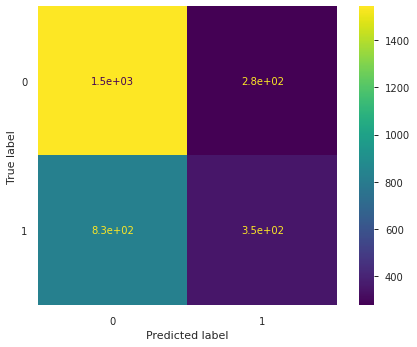

In [ ]:
# Se puede visualizar la matriz de confusión
plot_confusion_matrix(arbol_final, input_df_test, objective_variable_test)  
plt.show()  

In [55]:
arbol = DecisionTreeClassifier(random_state=0, criterion='gini', max_depth=7)

y_pred_train = arbol_final.predict(input_df_train)
y_pred_test = arbol_final.predict(input_df_test)
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(objective_variable_train, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(objective_variable_test, y_pred_test))

print('Métricas de predicción\n_________________________')
print('Exactitud: %.2f' % accuracy_score(objective_variable_test, y_pred_test))
print("Recall: {}".format(recall_score(objective_variable_test,y_pred_test)))
print("Precisión: {}".format(precision_score(objective_variable_test,y_pred_test)))
print("Puntuación F1: {}".format(f1_score(objective_variable_test,y_pred_test)))
print("\n")
print(classification_report(objective_variable_test, y_pred_test))

Exactitud sobre entrenamiento: 0.69
Exactitud sobre test: 0.63
Métricas de predicción
_________________________
Exactitud: 0.63
Recall: 0.29745762711864404
Precisión: 0.5598086124401914
Puntuación F1: 0.3884892086330935


              precision    recall  f1-score   support

           0       0.65      0.85      0.74      1820
           1       0.56      0.30      0.39      1180

    accuracy                           0.63      3000
   macro avg       0.61      0.57      0.56      3000
weighted avg       0.61      0.63      0.60      3000



### Segundo algoritmo - KNN


In [ ]:
X = X_count
Y = y_data
# Dividir los datos en entrenamiento y test
# Con este bloque tenemos la división de los datos de prueba y los de entrenamiento
# Tomaremos el 20% de los datos para hacer las pruebas.
size = 0.2

# input_df_test - Son los datos con los que probaremos el modelo
# objective_variable_test es la salida de la variable objetivo de los datos con los que probaremos el modelo
# input_df_train - Son los datos con los que entrenaremos el modelo
# objective_variable_train es la salida de los datos con la que probaremos el modelo

# objective_variable_test es la salida de la variable objetivo de los datos con los que probaremos el modelo
input_df_train, input_df_test, objective_variable_train, objective_variable_test =train_test_split(X, Y, test_size=size, random_state=0)


In [ ]:
# Utilicemos un número de vecinos = 7
modelo_knn = KNeighborsClassifier(n_neighbors=7)
modelo_knn = modelo_knn.fit(input_df_train, objective_variable_train)

In [ ]:
y_pred_train = modelo_knn.predict(input_df_train)
y_pred_test = modelo_knn.predict(input_df_test)
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(objective_variable_train, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(objective_variable_test, y_pred_test))

Exactitud sobre entrenamiento: 0.66
Exactitud sobre test: 0.62


In [53]:
print('Métricas de predicción\n_________________________')
print('Exactitud: %.2f' % accuracy_score(objective_variable_test, y_pred_test))
print("Recall: {}".format(recall_score(objective_variable_test,y_pred_test)))
print("Precisión: {}".format(precision_score(objective_variable_test,y_pred_test)))
print("Puntuación F1: {}".format(f1_score(objective_variable_test,y_pred_test)))
print("\n")
print(classification_report(objective_variable_test, y_pred_test))

Métricas de predicción
_________________________
Exactitud: 0.62
Recall: 0.06694915254237288
Precisión: 0.626984126984127
Puntuación F1: 0.12098009188361408


              precision    recall  f1-score   support

           0       0.62      0.97      0.76      1820
           1       0.63      0.07      0.12      1180

    accuracy                           0.62      3000
   macro avg       0.62      0.52      0.44      3000
weighted avg       0.62      0.62      0.51      3000



###Resultados de KNN


In [ ]:
X_n = X.copy()
X_n=(X_n-X_n.min())/(X_n.max()-X_n.min())
#X_n.describe

In [ ]:
input_df_train, input_df_test, objective_variable_train, objective_variable_test =train_test_split(X, Y, test_size=size, random_state=0)
modelo_Knn = KNeighborsClassifier(n_neighbors=7) 
modelo_Knn = modelo_knn.fit(input_df_train, objective_variable_train)

In [ ]:
# Lista de Hiperparámetros a afinar
n_vecinos = list(range(1,10))

param_grid = {'n_neighbors': n_vecinos, 'p': [1, 2]}

particiones = KFold(n_splits=10, shuffle=True, random_state = 0)

clasificadorKNN = KNeighborsClassifier()
modelo_Knn = GridSearchCV(clasificadorKNN, param_grid, cv= particiones)
modelo_Knn.fit(input_df_train,objective_variable_train) 
print("Mejor parámetro: {}".format(modelo_Knn.best_params_)) 
print("Mejor cross-validation score: {:.2f}".format(modelo_Knn.best_score_))

# Obtener el mejor modelo.
modelo_final = modelo_Knn.best_estimator_
# Probemos ahora este modelo sobre test.
y_pred_train = modelo_knn.predict(input_df_train)
y_pred_test = modelo_knn.predict(input_df_test)

print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(objective_variable_train, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(objective_variable_test, y_pred_test))

Mejor parámetro: {'n_neighbors': 7, 'p': 2}
Mejor cross-validation score: 0.63
Exactitud sobre entrenamiento: 0.66
Exactitud sobre test: 0.62


In [ ]:
y_pred_train = modelo_knn.predict(input_df_train)
y_pred_test = modelo_knn.predict(input_df_test)
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(objective_variable_train, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(objective_variable_test, y_pred_test))

Exactitud sobre entrenamiento: 0.66
Exactitud sobre test: 0.62


In [ ]:
#Ya con los valores dados podemos establcer los vecinos y p
clasificadorKNN = KNeighborsClassifier(n_neighbors = 7, p = 2)

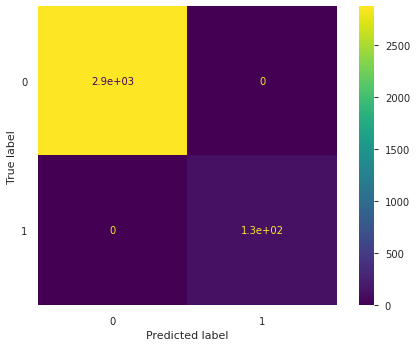

In [ ]:
# Se dibuja la matriz de confusion
plot_confusion_matrix(modelo_Knn, input_df_test, y_pred_test)
plt.show()

In [48]:
print('Métricas de predicción\n_________________________')
print('Exactitud: %.2f' % accuracy_score(objective_variable_test, y_pred_test))
print("Recall: {}".format(recall_score(objective_variable_test,y_pred_test)))
print("Precisión: {}".format(precision_score(objective_variable_test,y_pred_test)))
print("Puntuación F1: {}".format(f1_score(objective_variable_test,y_pred_test)))
print("\n")
print(classification_report(objective_variable_test, y_pred_test))

Métricas de predicción
_________________________
Exactitud: 0.62
Recall: 0.06694915254237288
Precisión: 0.626984126984127
Puntuación F1: 0.12098009188361408


              precision    recall  f1-score   support

           0       0.62      0.97      0.76      1820
           1       0.63      0.07      0.12      1180

    accuracy                           0.62      3000
   macro avg       0.62      0.52      0.44      3000
weighted avg       0.62      0.62      0.51      3000



In [49]:
# Determinamos las predicciones del modelo sobre el conjunto test.
objective_variable_predictions_forest = clf.predict(input_df_test)

NameError: ignored

El tercer algoritmo que se implementará será random forest, ya que es un algoritmo que ayuda con la tarea de clasificación que se planea resolver

In [50]:
X = X_count
Y = y_data
# Dividir los datos en entrenamiento y test
# Con este bloque tenemos la división de los datos de prueba y los de entrenamiento
# Tomaremos el 20% de los datos para hacer las pruebas.
size = 0.2

# input_df_test - Son los datos con los que probaremos el modelo
# objective_variable_test es la salida de la variable objetivo de los datos con los que probaremos el modelo
# input_df_train - Son los datos con los que entrenaremos el modelo
# objective_variable_train es la salida de los datos con la que probaremos el modelo

# objective_variable_test es la salida de la variable objetivo de los datos con los que probaremos el modelo
input_df_train, input_df_test, objective_variable_train, objective_variable_test =train_test_split(X, Y, test_size=size, random_state=0)


In [51]:
#Se analizarán los hiperparámetros del algorimto, cual genera mejores resultados
# Fijemos el número de particiones. Utilizaremos K = 10.
particiones = KFold(n_splits=10, shuffle=True, random_state = seed)
# Establecemos el espacio de búsqueda para los hiperparámetros que deseamos ajustar. 
param_grid = {'criterion':['gini', 'entropy'],'max_depth':[50, 100, 200],'n_estimators':[10, 20, 30, 50],'min_samples_split':[3, 4, 5]}
# Definimos el modelo sin ningún valor de estos hiperparámetros
arbol = RandomForestClassifier(random_state=seed)
# Ahora utilizamos GridSearch sobre el grid definido y con 10 particiones en la validación cruzada.
mejor_modelo = GridSearchCV(arbol, param_grid, cv=particiones)
# Ajuste del modelo
#mejor_modelo.fit(input_df_train, objective_variable_train)
# Podemos ver cuál fue el resultado de la búsqueda (mejores valores de hiperparámetros)
#mejor_modelo.best_params_

In [52]:
## Crear el objeto de random forest classifier. Utilicemos como criterio de pureza la entropía que está por defecto,
#la profundidad máxima de cada árbol será de 2 y se crearán 10 árboles para la estimación.
clf = RandomForestClassifier(criterion = 'entropy',max_depth= 100, n_estimators= 200, random_state=seed)
# Entrenar el modelo de random forest con los datos de entrenamiento
clf = clf.fit(input_df_train, objective_variable_train)

In [56]:
# Determinamos las predicciones del modelo sobre el conjunto test.
objective_variable_predictions_forest = clf.predict(input_df_test)

In [57]:

# Se genera la matriz de confusión
cm = confusion_matrix(objective_variable_test, objective_variable_predictions_forest)
cm

array([[1644,  176],
       [ 799,  381]])

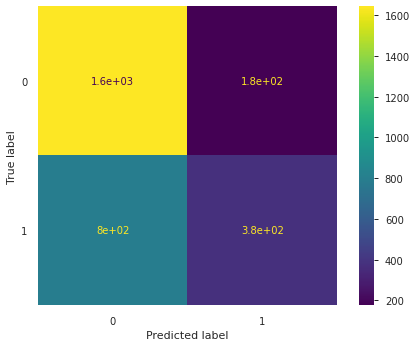

In [58]:
# Se visualiza la matriz de confusión
plot_confusion_matrix(clf, input_df_test, objective_variable_test)  
plt.show()

In [59]:
print('Métricas de predicción\n_________________________')
print('Exactitud: %.2f' % accuracy_score(objective_variable_test, objective_variable_predictions_forest))
print("Recall: {}".format(recall_score(objective_variable_test,objective_variable_predictions_forest)))
print("Precisión: {}".format(precision_score(objective_variable_test,objective_variable_predictions_forest)))
print("Puntuación F1: {}".format(f1_score(objective_variable_test,objective_variable_predictions_forest)))
print("\n")
print(classification_report(objective_variable_test, objective_variable_predictions_forest))

Métricas de predicción
_________________________
Exactitud: 0.68
Recall: 0.3228813559322034
Precisión: 0.6840215439856373
Puntuación F1: 0.4386873920552677


              precision    recall  f1-score   support

           0       0.67      0.90      0.77      1820
           1       0.68      0.32      0.44      1180

    accuracy                           0.68      3000
   macro avg       0.68      0.61      0.60      3000
weighted avg       0.68      0.68      0.64      3000

